![alt text](img/LM.png)
# Kurs: Deep Learning, Text Mining i XAI w Pythonie

## Autor: Piotr Ćwiakowski

### Lekcja 1B. Liczby Shapleya - case study

# 1. Przygotowanie danych

In [1]:
import pickle
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import shap
import xgboost as xgb

In [2]:
diamonds = pd.read_csv('data/diamonds.csv', index_col=0)
diamonds.head()

,carat,cut,color,clarity,depth,table,price,x,y,z
1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [3]:
for var in ['color', 'clarity', 'cut']:
    diamonds[var] = (pd.Categorical(diamonds[var])).codes

In [4]:
features = diamonds.columns.tolist()
features.remove('price')
print(features)

['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'x', 'y', 'z']


In [5]:
# Podzielenie zbioru na część treningową i testową
X_train, X_valid, y_train, y_valid = train_test_split(diamonds[features], diamonds['price'], test_size=0.15, random_state=2023, shuffle=True)

In [6]:
X_train.shape, X_valid.shape

((45849, 9), (8091, 9))

# 2. Przygotowanie modelu

In [7]:
model = xgb.XGBRegressor(n_estimators=1000, tree_method="hist", random_state=2023).fit(X_train, y_train)

predsTrain = model.predict(X_train)
rmseTrain = mean_squared_error(y_train, predsTrain, squared=False)

predsTest = model.predict(X_valid)
rmseTest = mean_squared_error(y_valid, predsTest, squared=False)

rmseTrain, rmseTest

(157.1813514643521, 567.9941100386279)

# 3. Przygotowanie modelu Shapley'a

In [8]:
xgb_explainer = shap.TreeExplainer(model, X_train, feature_names=X_train.columns.tolist())
xgb_explainer

In [10]:
%%time

# Shap values with tree explainer
shap_values = xgb_explainer.shap_values(X_test, y_test)

100%|===================| 45830/45849 [38:05<00:00]        

CPU times: total: 37min 49s
Wall time: 38min 8s


In [8]:
import pickle

# with open('shap_val.p', 'wb') as fp:
#     pickle.dump(shap_values, fp)
    
with open('shap_val.p', 'rb') as fp:
    shap_values = pickle.load(fp)

Szybszy sposób:

In [9]:
# %%time

# booster_xgb = model.get_booster()
# shap_values = booster_xgb.predict(xgb.DMatrix(X_train, y_train), pred_contribs=True)

CPU times: total: 13min 24s
Wall time: 1min 51s


In [11]:
X_train

,carat,cut,color,clarity,depth,table,x,y,z
46680,0.99,0,6,0,73.6,60.0,6.01,5.80,4.35
34227,0.40,3,4,2,62.7,58.0,4.69,4.65,2.93
5708,0.25,4,2,7,59.0,58.0,4.10,4.14,2.43
42531,0.40,2,2,6,62.5,57.0,4.75,4.72,2.96
12710,0.26,2,2,6,62.4,56.0,4.10,4.11,2.56
...,...,...,...,...,...,...,...,...,...
38621,0.31,1,4,5,63.1,57.0,4.27,4.32,2.71
38818,0.39,2,5,4,62.5,54.0,4.70,4.67,2.92
51896,0.73,2,1,3,62.8,55.0,5.73,5.76,3.61
47559,0.70,2,5,3,62.3,55.0,5.67,5.72,3.55


In [39]:
shapDf = pd.DataFrame(shap_values, columns=X_train.columns.tolist())

ValueError: Shape of passed values is (45849, 9), indices imply (45849, 10)

In [10]:
shapDf.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,-2419.334120,51.064185,270.427065,-27.463326,-14.785765,-14.031713,-137.146860,-599.949862,-124.148271
1,-478.576797,114.732676,-7.235155,-59.310122,63.323023,36.478281,239.060258,12.533255,-28.778597
2,-953.404956,4.383095,362.704161,-68.185910,-98.385787,-17.645170,200.046742,-315.996739,32.957952
3,7540.071021,4.088255,574.413087,-1348.461041,-2.055409,-176.141875,-822.945221,1625.279785,-209.219093
4,-2289.018798,48.638826,16.650421,-15.473105,24.542549,13.228837,-169.609870,-616.146054,-161.626990


In [14]:
 shap_values.shape

(45849, 9)

# 4. Interpretacje globalne

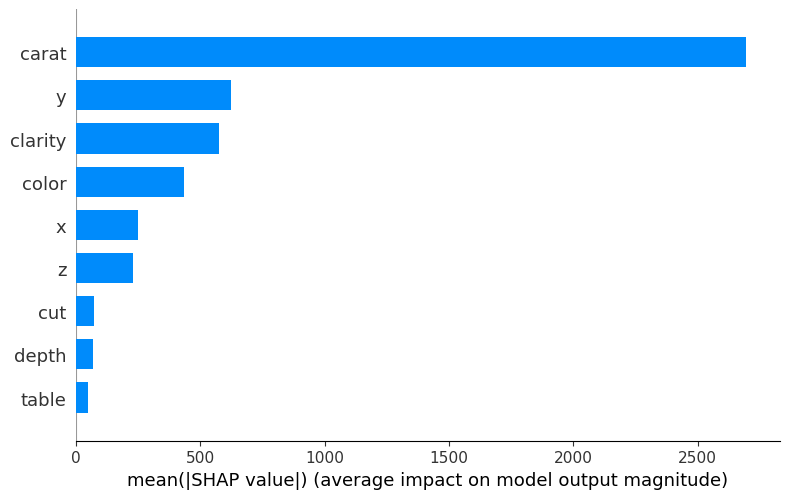

In [12]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns, plot_type="bar")
# shap.summary_plot(shap_values[:,:-1], X_train, feature_names=X_train.columns, plot_type="bar")

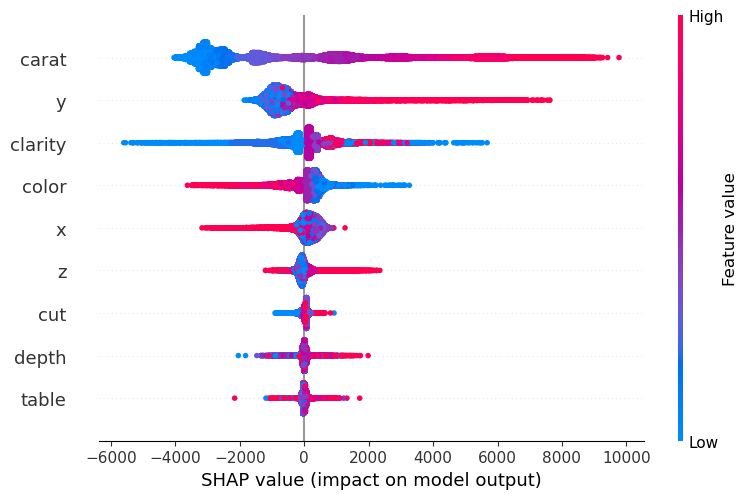

In [17]:
shap.summary_plot(shap_values, X_train, feature_names=X_train.columns)
# shap.summary_plot(shap_values[:,:-1], X_train, feature_names=X_train.columns)

<Axes: >

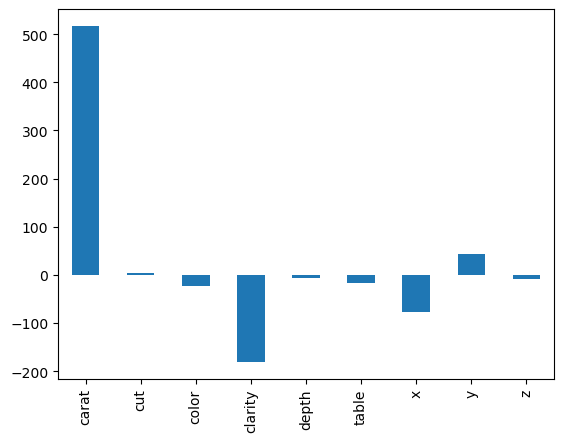

In [57]:
shapDf.mean().iloc[:-2].plot(kind='bar')

<Axes: >

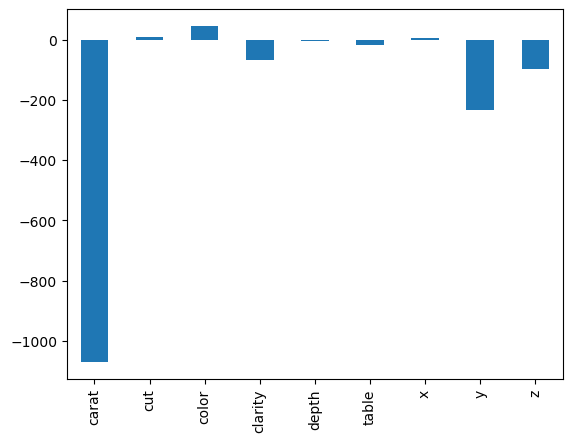

In [58]:
shapDf.median().iloc[:-2].plot(kind='bar')

In [18]:
shapDf.abs().mean()
# shapDf.iloc[:,:-1].abs().mean()

carat      2723.640752
cut          79.889954
color       450.236535
clarity     620.874367
depth        71.886494
table        58.802757
x           291.931816
y           918.494584
z           151.454104
dtype: float64

<Axes: xlabel='carat', ylabel='price'>

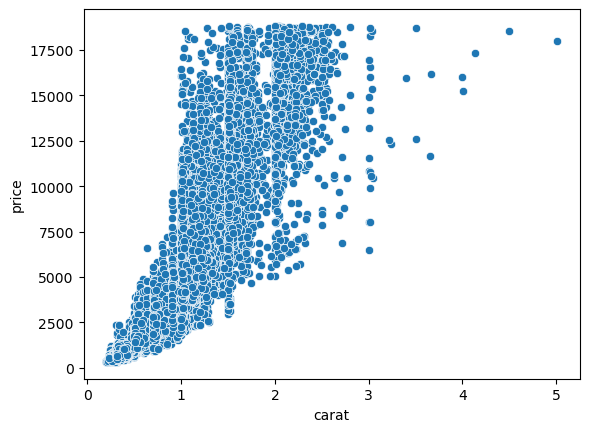

In [16]:
sns.scatterplot(data=X_train, x=X_train['carat'], y=y_train)

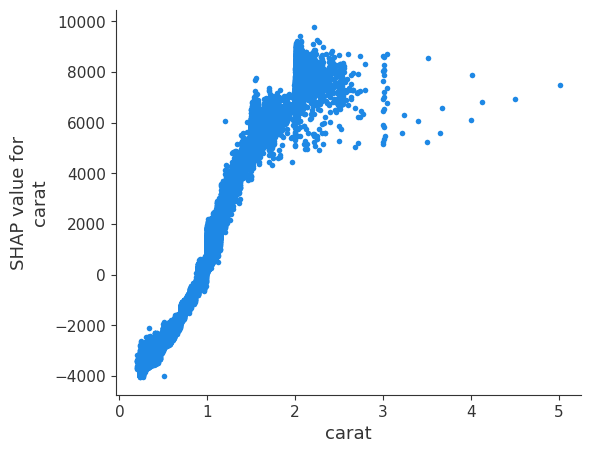

In [19]:
shap.dependence_plot("carat", shap_values, X_train, interaction_index=None)
# shap.dependence_plot("carat", shap_values[:,:-1], X_train, interaction_index=None)

In [31]:
X_train['pred'] = y_train
X_train.groupby('clarity').agg({'pred':'mean'}).round()

shapDf['pred'] = y_train
shapDf['clarityV'] = X_train['clarity']
shapDf.groupby('clarityV').agg({'clarity':'mean'}).round()

resShap = pd.concat([X_train.groupby('clarity').agg({'pred':'mean'}).round(), shapDf.groupby('clarityV').agg({'clarity':'mean'}).round()], axis=1)
resShap.columns = ['y', 'shap']
resShap

,y,shap
0.0,3931.0,-223.0
1.0,2833.0,-181.0
2.0,3981.0,-182.0
3.0,5094.0,-182.0
4.0,3835.0,-158.0
5.0,3934.0,-185.0
6.0,2532.0,-174.0
7.0,3295.0,-181.0


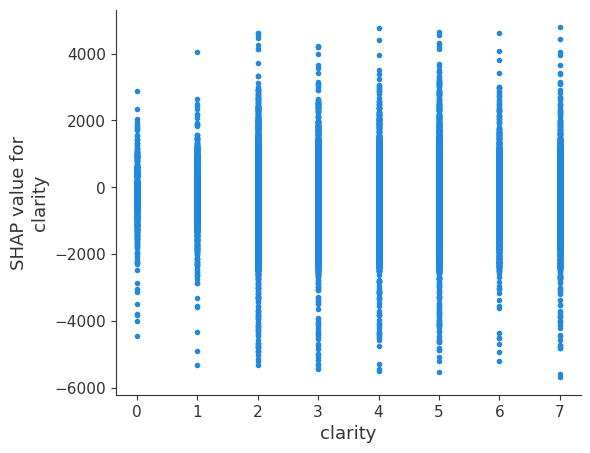

In [17]:
shap.dependence_plot("clarity", shap_values, X_train, interaction_index=None)
# shap.dependence_plot("carat", shap_values[:,:-1], X_train, interaction_index=None)

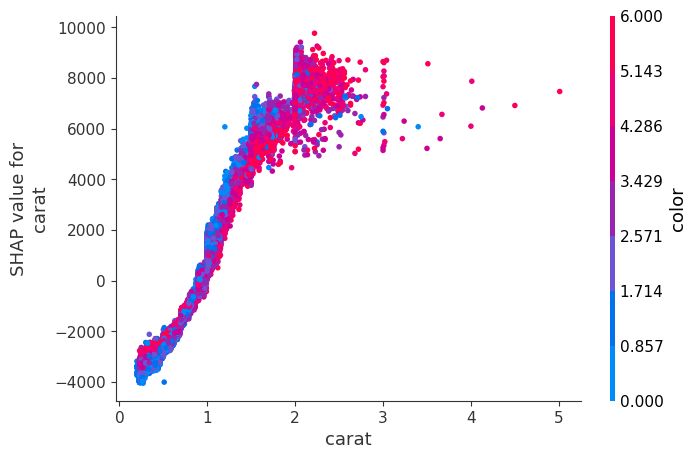

In [20]:
shap.dependence_plot("carat", shap_values, X_train, interaction_index='auto')
# shap.dependence_plot("carat", shap_values[:,:-1], X_train, interaction_index='auto')

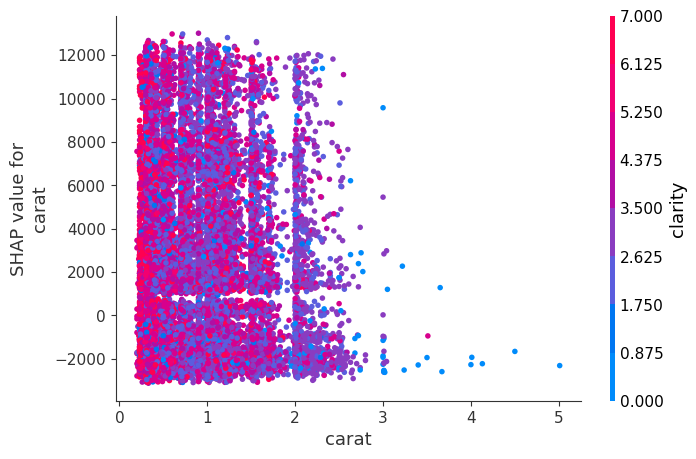

In [42]:
shap.dependence_plot("carat", shap_values, X_train.iloc[:,:-1], interaction_index='clarity')
# shap.dependence_plot("carat", shap_values, X_train, interaction_index='clarity')

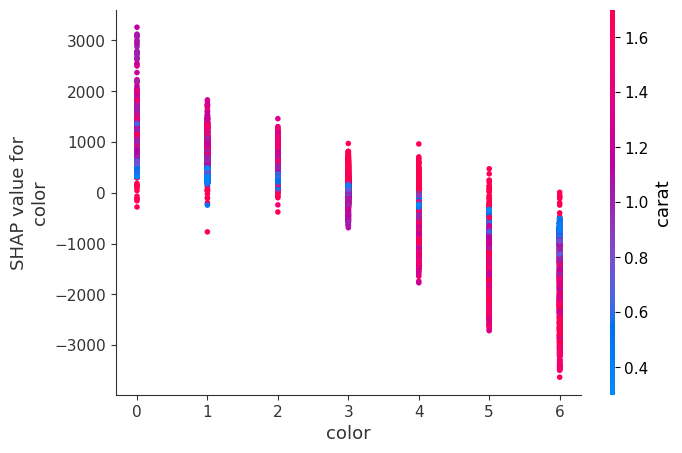

In [21]:
shap.dependence_plot("color", shap_values, X_train, feature_names=X_train.columns);
# shap.dependence_plot("color", shap_values[:,:-1], X_train, feature_names=X_train.columns);

In [22]:
# Więcej opcji formatowania:
# https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html

In [23]:
shapDf.head()

,carat,cut,color,clarity,depth,table,x,y,z
0,-291.363711,-229.154113,-533.952179,-1451.594948,160.880256,-64.673428,463.538134,-528.781585,-60.971829
1,-2966.109104,10.866991,-11.288158,-94.921083,30.580686,-1.357723,82.283624,-513.247999,-33.101757
2,-3604.785493,71.550648,389.919465,753.686137,-101.018202,22.706690,-292.568926,-859.648293,-127.846124
3,-3317.936357,53.302761,380.693305,1056.167029,-35.295287,-37.201589,278.041721,-1229.623772,-149.768999
4,-3687.562381,36.168030,400.011243,991.278778,-31.851192,-51.688258,-86.813903,-1154.761079,-98.045659


Policzenie interakcji:

In [26]:
# z jakiegoś powodu nie działa:
# interactions = xgb_explainer.shap_interaction_values(X_valid)

In [21]:
%%time

# SHAP interactions with XGB
interactions_xgb = booster_xgb.predict(xgb.DMatrix(X_train, y_train), pred_interactions=True)

CPU times: total: 4h 19min 42s
Wall time: 37min 55s


In [22]:
interactions_xgb.shape

(45849, 10, 10)

In [25]:
# with open('shap_val_int.p', 'wb') as fp:
#     pickle.dump(interactions_xgb, fp)
    
with open('shap_val_int.p', 'rb') as fp:
    interactions_xgb = pickle.load(fp)

In [54]:
interactions_xgb.shape

(45849, 10, 10)

In [93]:
def get_top_k_interactions(feature_names, shap_interactions, k):
    # Get the mean absolute contribution for each feature interaction
    aggregate_interactions = np.mean(np.abs(shap_interactions[:, :-1, :-1]), axis=0)
    interactions = []
    for i in range(aggregate_interactions.shape[0]):
        for j in range(aggregate_interactions.shape[1]):
            if j < i:
                interactions.append(
                    (
                        feature_names[i] + "-" + feature_names[j],
                        aggregate_interactions[i][j],
                    )
                )
    # sort by magnitude
    interactions.sort(key=lambda x: x[1], reverse=True)
    interaction_features, interaction_values = map(tuple, zip(*interactions))

    return interaction_features[:k], interaction_values[:k]


top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

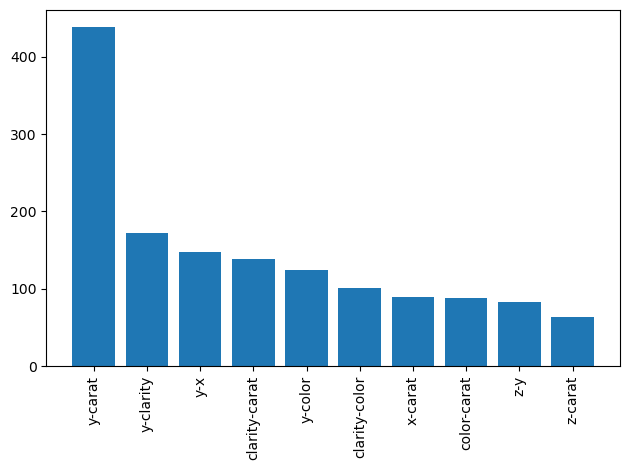

In [94]:
def plot_interaction_pairs(pairs, values):
    plt.bar(pairs, values)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show();
    

top_10_inter_feats, top_10_inter_vals = get_top_k_interactions(
    X_train.columns, interactions_xgb, 10
)

plot_interaction_pairs(top_10_inter_feats, top_10_inter_vals)

(9, 9)


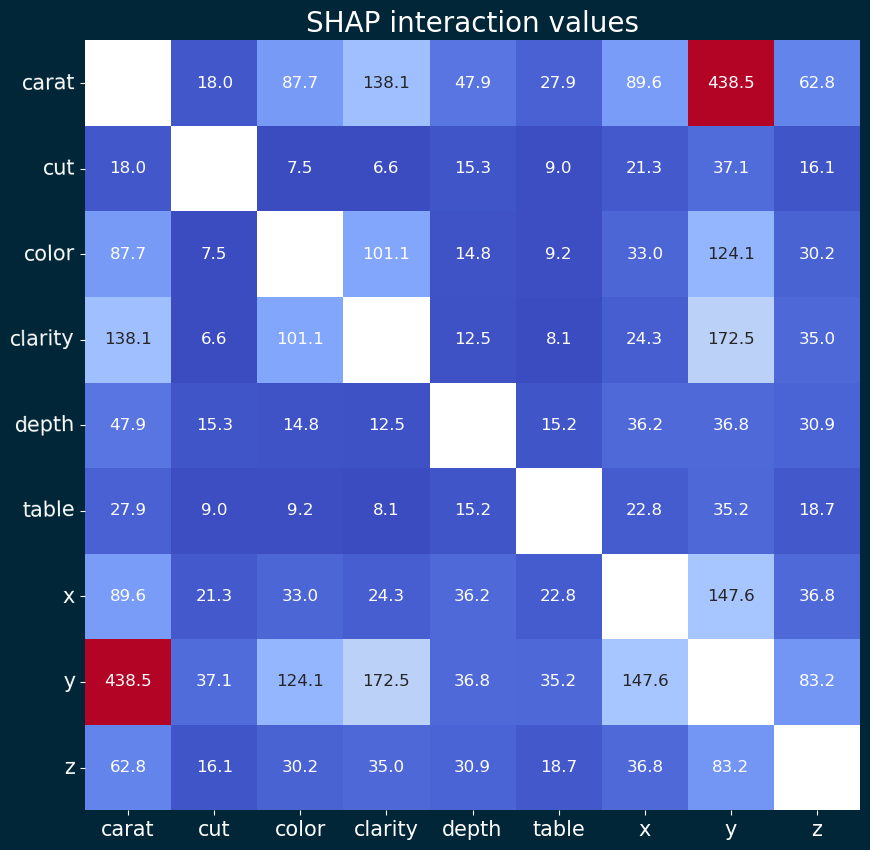

In [95]:
# Get absolute mean of matrices
mean_shap = np.abs(interactions_xgb[:,:9,:9]).mean(0)
df = pd.DataFrame(mean_shap, index=X_train.columns, columns=X_train.columns)
print(df.shape)

df.where(~(df.values == np.diagonal(df)),np.nan, inplace=True)

# display 
fig = plt.figure(figsize=(10, 10), facecolor='#002637', edgecolor='r')
ax = fig.add_subplot()
sns.heatmap(df.round(decimals=1), cmap='coolwarm', annot=True, fmt='.1f', cbar=False, ax=ax, annot_kws={"size":12}, )
ax.tick_params(axis='x', colors='w', labelsize=15)
ax.tick_params(axis='y', colors='w', labelsize=15)

ax.set_title("SHAP interaction values", color="white", fontsize=20)
plt.yticks(rotation=1) ;

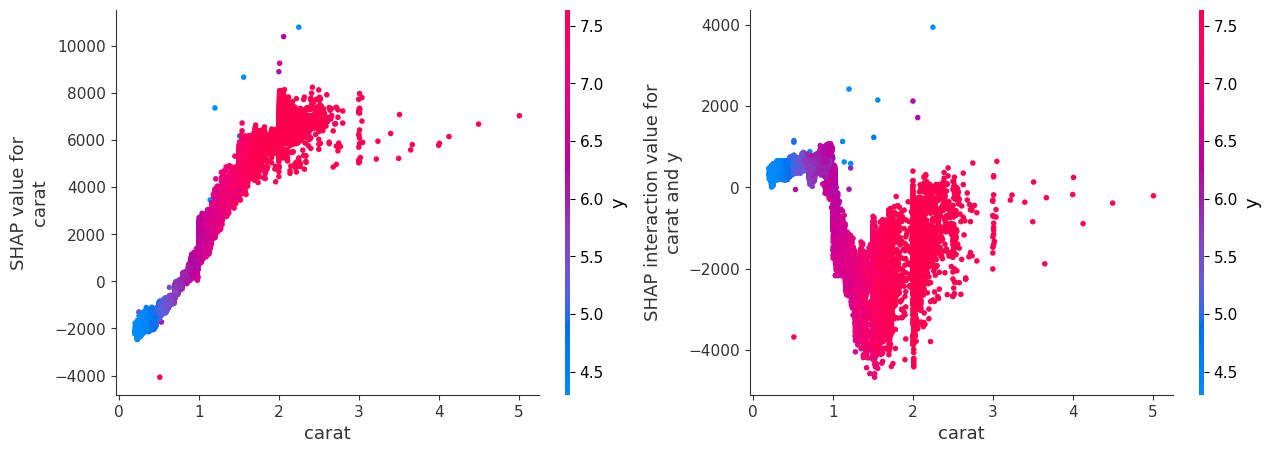

In [90]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))


shap.dependence_plot('carat', shap_values[:,:9], X_train, display_features=X_train, interaction_index='y', ax=ax[0], show=False)
shap.dependence_plot(('carat', 'y'), interactions_xgb[:,:9,:9], X_train, display_features=X_train, ax=ax[1], show=False)

# 5. Interpretacje lokalne

In [24]:
idx = 6559 

In [25]:
%%time

# Recalculate SHAP values
shap_explainer_values = xgb_explainer(X_train, y_train)

100%|===================| 45840/45849 [28:42<00:00]        

CPU times: total: 28min 35s
Wall time: 28min 43s


In [45]:
# with open('shap_exp_val.p', 'wb') as fp:
#     pickle.dump(shap_explainer_values, fp)
    
with open('shap_exp_val.p', 'rb') as fp:
    shap_explainer_values = pickle.load(fp)

In [26]:
type(shap_explainer_values)

shap._explanation.Explanation

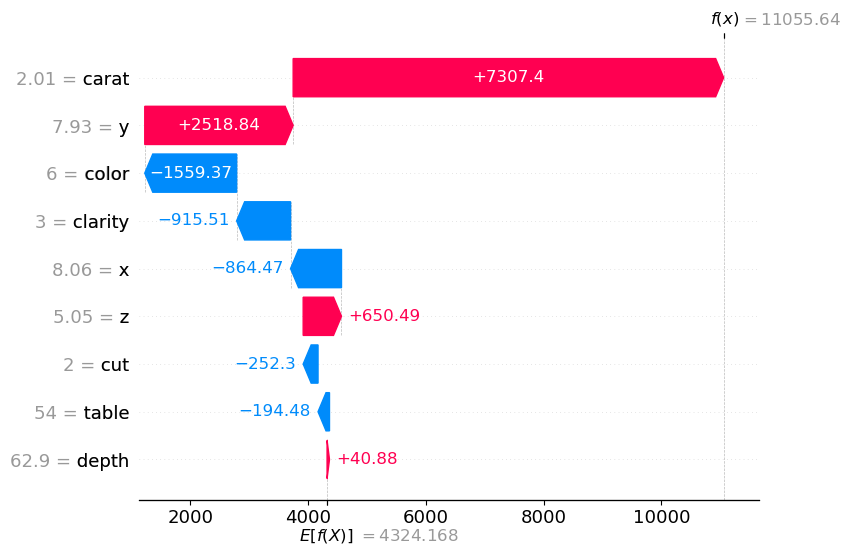

In [27]:
shap.waterfall_plot(shap_explainer_values[6559])

In [28]:
X_train.query('carat==2.01 and y==7.93 and color==6')

,carat,cut,color,clarity,depth,table,x,y,z
22964,2.01,2,6,3,62.9,54.0,8.06,7.93,5.05


In [47]:
shap_explainer_values.values

array([[ -291.36371113,  -229.15411339,  -533.9521795 , ...,
          463.53813432,  -528.78158476,   -60.97182922],
       [-2966.10910379,    10.86699088,   -11.28815771, ...,
           82.2836239 ,  -513.247999  ,   -33.10175658],
       [-3604.78549348,    71.55064799,   389.91946529, ...,
         -292.56892629,  -859.64829319,  -127.84612412],
       ...,
       [-1442.63740215,    78.79598135,   280.53129842, ...,
          589.33209762,  -532.61817885,   -95.86826752],
       [-1396.90627615,    63.40976835,  -439.00514151, ...,
          520.93562194,  -545.53912169,   -68.60477974],
       [-2690.71703769,    44.6675878 ,  -481.6312171 , ...,
          106.33208618,  -882.83290274,    17.15716358]])

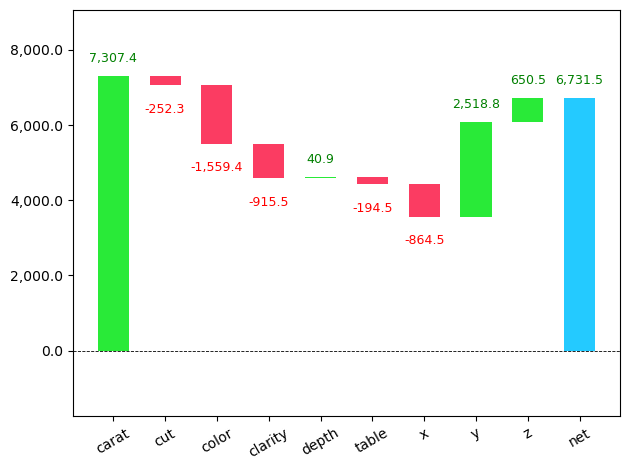

In [51]:
# !pip install waterfallcharts

import waterfall_chart
import matplotlib.pyplot as plt
a = X_train.columns.tolist()[:-1]
b = shap_explainer_values.values[6559]
waterfall_chart.plot(a, b);

In [52]:
shap.initjs() 

In [53]:
shap.force_plot(shap_explainer_values[6559])

Źródło: 

* https://towardsdatascience.com/a-complete-shap-tutorial-how-to-explain-any-black-box-ml-model-in-python-7538d11fae94
* https://towardsdatascience.com/shap-explained-the-way-i-wish-someone-explained-it-to-me-ab81cc69ef30
* https://arxiv.org/abs/1705.07874
* https://medium.com/dataman-in-ai/explain-your-model-with-the-shap-values-bc36aac4de3d
* https://shap.readthedocs.io/en/latest/example_notebooks/tabular_examples/tree_based_models/Basic%20SHAP%20Interaction%20Value%20Example%20in%20XGBoost.html
* https://mindfulmodeler.substack.com/p/shap-is-not-all-you-need